# Titanic: Machine Learning from Disaster

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import  cross_validation, tree, preprocessing, metrics
from IPython.display import Image 
import pydotplus

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_data = pd.read_csv('./data/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 数据集说明
共 11 个属性和 1 个标记。

| | | | | | | | | | | | 
| :--: |:--: | :--: | :--: |:--: |:--: |:--: |:--: |:--: |:--: |:--: |
| PassengerId| Pclass| Name| Sex|Age |SibSp | Parch| Ticket|Fare |Cabin | Embarked| 
| 乘客ID| 舱位等级| 姓名 | 性别 | 年龄 |船上同辈个数 |船上不同辈个数 |票号 |票价| 客舱号|登船港口 | 

Survived: 是否获救
* 0 = 没有
* 1 = 获救

## 数据初步分析
根据常识，影响是否获救的因素应该主要跟以下几个因素有关：
* 舱位等级
* 性别
* 年龄
* 票价 (与舱位等级相关)

主要使用上述4个特征，先查看以下这 4 个变量的情况以及和是否获救的关系。

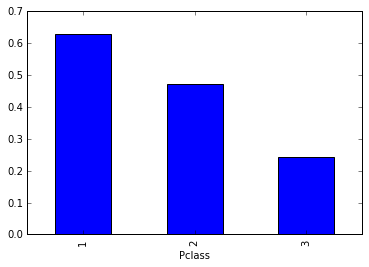

In [3]:
train_data.groupby('Pclass').mean()['Survived'].plot.bar()

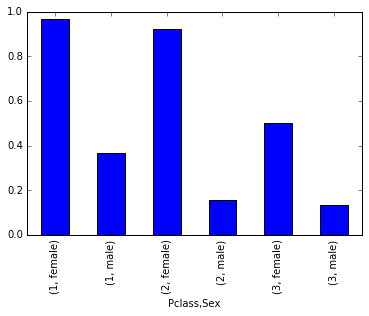

In [4]:
train_data.groupby(['Pclass','Sex']).mean()['Survived'].plot.bar()

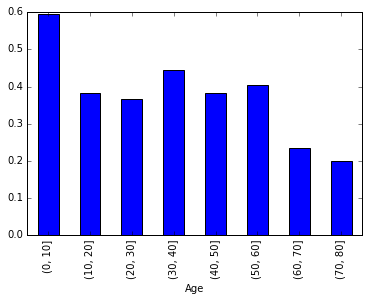

In [5]:
age_range = pd.cut(train_data["Age"], np.arange(0, 90, 10))
train_data.groupby([age_range]).mean()['Survived'].plot.bar()

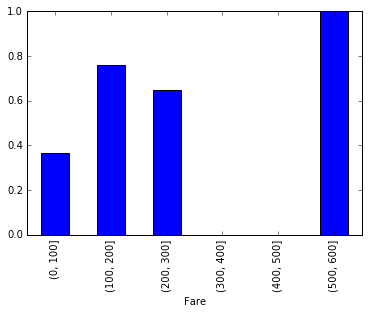

In [6]:
fare_range = pd.cut(train_data["Fare"], np.arange(0, 700, 100))
train_data.groupby([fare_range]).mean()['Survived'].plot.bar()

可以看出，由于泰塔尼克的施救原则，性别是影响是否获救的最大因素，其次为舱位等级、票价、年龄。由于舱位等级和票价高度相关，这里先不考虑票价。

## 数据预处理

In [7]:
train_data = train_data.drop(['PassengerId','Name','SibSp','Parch','Ticket','Cabin','Embarked','Fare'], axis=1)
train_data.count()

Survived    891
Pclass      891
Sex         891
Age         714
dtype: int64

In [8]:
# 填充 age
train_data['Age'] = train_data['Age'].fillna(value=train_data.Age.mean())
# 将性别转换为 0，1
train_data['Sex'] = preprocessing.LabelEncoder().fit_transform(train_data['Sex'])
# 将Pclass转换为 P_1, P_2, P_3 三个变量
#pclass = pd.get_dummies(train_data['Pclass'],prefix='P')
#train_data = train_data.drop(['Pclass'], axis=1)
#train_data = pd.concat([pclass,train_data], axis=1)
#
X = train_data.drop(['Survived'], axis=1).values
y = train_data['Survived'].values

## 生成决策树

In [9]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.22)
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth = 3)
clf.fit (X_train, y_train)
clf.score (X_test, y_test)

0.81218274111675126

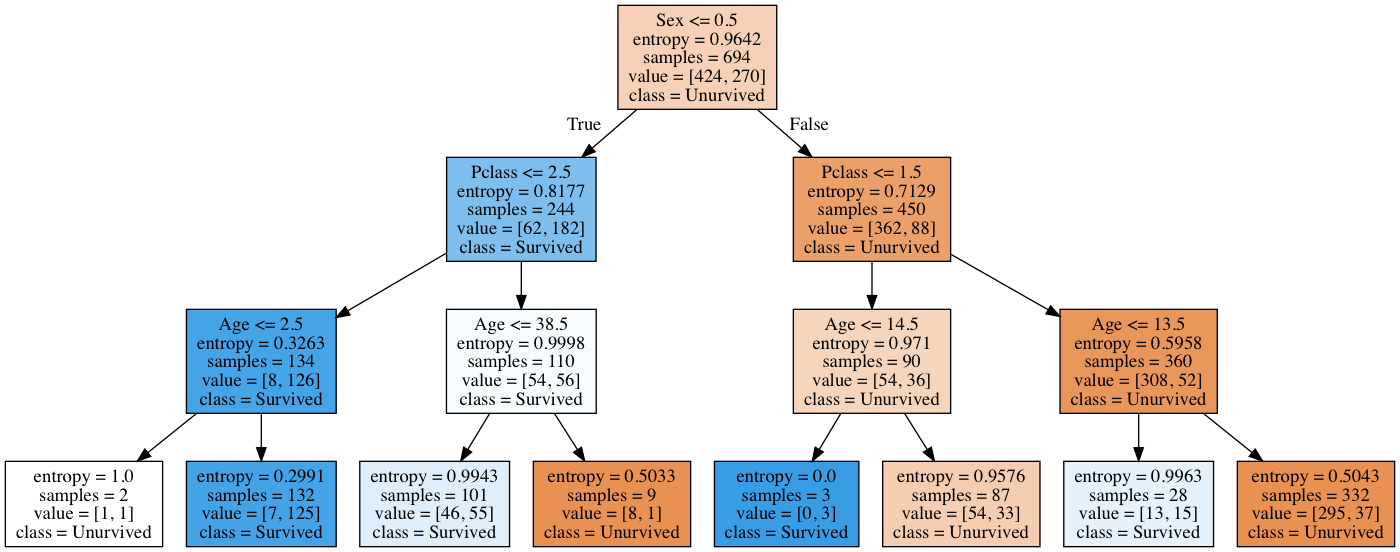

In [10]:
name = train_data.drop(['Survived'], axis=1).columns
label = ["Unurvived","Survived"]
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=name, class_names=label,filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## 模型评估

In [11]:
predict = clf.predict(X)
print(metrics.classification_report(y, predict))

             precision    recall  f1-score   support

          0       0.84      0.85      0.84       549
          1       0.75      0.74      0.74       342

avg / total       0.80      0.80      0.80       891



In [12]:
scores = cross_validation.cross_val_score(clf, X, y, cv=10)
scores.mean()

0.80129298604017696